## WiDS Datathon 2019

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
image_dir = '/mnt/disks/disk3/widsdatathon2019/train_images/'
df = pd.read_csv('traininglabels.csv')

In [3]:
test = glob.glob("/mnt/disks/disk3/widsdatathon2019/leaderboard_test_data/*.jpg")
#holdout = glob.glob("/mnt/disks/disk3/widsdatathon2019/leaderboard_holdout_data/*.jpg")
X_test = pd.DataFrame(test,columns=['filename'])['filename'].apply(lambda x: x.split("/")[-1])

In [4]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [5]:
df.info() # no missing value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15244 entries, 0 to 15243
Data columns (total 3 columns):
image_id       15244 non-null object
has_oilpalm    15244 non-null int64
score          15244 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 357.4+ KB


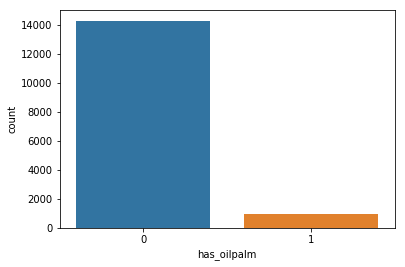

In [6]:
# countplot 
sns.countplot(df['has_oilpalm'])

In [7]:
sample = df.sample(n=15)
f_name = sample['image_id'].values
label = sample['has_oilpalm'].values
score = sample['score'].values

### Visualization 

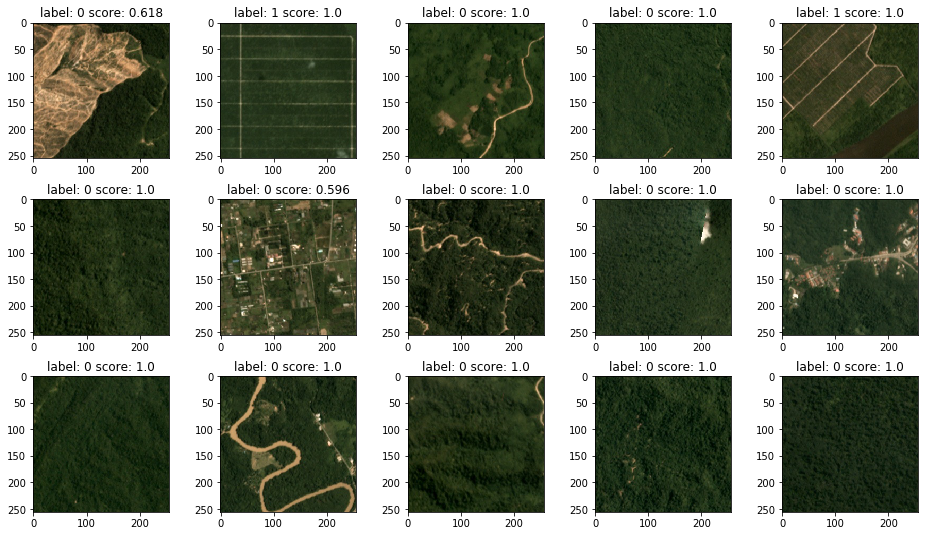

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

fig=plt.figure(figsize=(16, 9))
count = 0
for i in f_name:
    im = Image.open(image_dir + i)
    count = count+1
    fig.add_subplot(3, 5, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(im)
    plt.title('label: '+str(label[count-1])+' '+ 'score: '+str(round(score[count-1],3)))

In [8]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential

Using TensorFlow backend.


In [9]:
df_1 = df[df['has_oilpalm']==0].sample(frac=0.1)
df_2 = df[df['has_oilpalm']==1]
dt_m = pd.concat([df_1,df_2]).reset_index(drop=True)
dt_m.groupby('has_oilpalm').count()['image_id']

has_oilpalm
0    1430
1     942
Name: image_id, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
#Splitting 
y = dt_m['has_oilpalm']
X = dt_m['image_id']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 

In [11]:
# Original Dimensions
image_width = 256
image_height = 256
channels = 3

In [12]:
def CreateDataset(X,image_dir,image_width,image_height,channels):
    dataset_X = np.ndarray(shape=(len(X),image_height, image_width, channels),
                     dtype=np.float32)
    i = 0
    for _file in X.values:
        img = load_img(image_dir + _file)  # this is a PIL image
        img.thumbnail((image_width, image_height))
        # Convert to Numpy Array
        x = img_to_array(img)  
        # Normalize
        x = (x - x.max()) / x.max()
        dataset_X[i] = x
        i += 1
    return dataset_X

In [13]:
dataset_X_train = CreateDataset(X_train,image_dir,image_width,image_height,channels)

In [14]:
dataset_X_val = CreateDataset(X_val,image_dir,image_width,image_height,channels)

In [15]:
dataset_X_test = CreateDataset(X_test,'/mnt/disks/disk3/widsdatathon2019/leaderboard_test_data/',\
            image_width,image_height,channels)

In [18]:
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import adam

input_shape = (image_width, image_height, 3)


cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(1, activation='sigmoid'))

    
cnn1.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [19]:
history = cnn1.fit(dataset_X_train, y_train,\
                    batch_size=32, epochs=5,verbose=1,validation_data=(dataset_X_val, y_val))
score = cnn1.evaluate(dataset_X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1897 samples, validate on 475 samples
Epoch 1/5
1897/1897 [==============================] - 105s 55ms/step - loss: 9.5267 - acc: 0.3948 - val_loss: 9.4647 - val_acc: 0.4063
Epoch 2/5
1897/1897 [==============================] - 97s 51ms/step - loss: 9.6478 - acc: 0.3948 - val_loss: 9.4647 - val_acc: 0.4063
Epoch 3/5
1897/1897 [==============================] - 97s 51ms/step - loss: 9.6478 - acc: 0.3948 - val_loss: 9.4647 - val_acc: 0.4063
Epoch 4/5
1897/1897 [==============================] - 96s 50ms/step - loss: 9.6478 - acc: 0.3948 - val_loss: 9.4647 - val_acc: 0.4063
Epoch 5/5
1897/1897 [==============================] - 96s 51ms/step - loss: 9.6478 - acc: 0.3948 - val_loss: 9.4647 - val_acc: 0.4063
Test loss: 9.46474275689376
Test accuracy: 0.4063157895677968


In [43]:
def CNNModel(input_shape):
    #input_shape -- shape of the images of the dataset
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='CNNModel')
    
    return model

In [44]:
CNNModel = CNNModel((256,256,3))

In [45]:
CNNModel.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
CNNModel.fit(x=dataset_X_train,y=y_train,epochs=5, batch_size=128, verbose=1)

Epoch 1/5
1219/1219 [==============================] - 202s 166ms/step - loss: 0.8932 - acc: 0.9016
Epoch 2/5
1219/1219 [==============================] - 198s 162ms/step - loss: 0.9256 - acc: 0.9426
Epoch 3/5
1219/1219 [==============================] - 200s 164ms/step - loss: 0.9256 - acc: 0.9426
Epoch 4/5
 896/1219 [=====================>........] - ETA: 52s - loss: 0.8275 - acc: 0.9487 

KeyboardInterrupt: 